In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def make_surface(nx=16, ny=16, m=1, n=1, lx=1., ly=1., amp=1., noise=1):
    xx = np.linspace(-0.5, 0.5, nx) * lx
    yy = np.linspace(-0.5, 0.5, ny) * ly
    x, y = np.meshgrid(xx, yy, indexing="ij")
    phi = np.random.rand() * 2. * np.pi
    oz = np.zeros((nx, ny), dtype=np.complex)
    oz[m, n] = np.sin(phi) + 1j * np.cos(phi)
    oz[-m, -n] = np.sin(phi) - 1j * np.cos(phi)
    oz = oz.transpose() * (nx * ny / 2) * amp / 2.
    oi = np.fft.ifftn(oz)
    
#     os = np.fft.fftshift(oz)
#     fig,ax = plt.subplots(1,3)
#     ax[0].imshow(np.abs(os))
#     ax[1].imshow(np.real(oi))
#     ax[2].imshow(np.imag(oi))
#     plt.show()
    
    oi = oi + noise * np.random.randn(nx, ny)
    return x, y, np.real(oi)

In [35]:
def make_param_list(mirror_params):
    """ミラー毎の楕円のパラメータをランダム作成関数"""

    ellipse_nums = []
    param_list = []

    for dat_i in range(mirror_params['dat_num']):

        ellipse_nums.append(np.random.randint(mirror_params['elip_num_min'], mirror_params['elip_num_max']))

        init_elip_len_x_list = np.random.randint(mirror_params['elip_len_x_min'], mirror_params['elip_len_x_max'], size=ellipse_nums[dat_i])
        init_elip_len_y_list = np.random.randint(mirror_params['elip_len_y_min'], mirror_params['elip_len_y_max'], size=ellipse_nums[dat_i])
        init_coord_x_list = np.random.randint(mirror_params['coord_x_min'], mirror_params['coord_x_max'], size=ellipse_nums[dat_i])
        init_coord_y_list = np.random.randint(mirror_params['coord_y_min'], mirror_params['coord_y_max'], size=ellipse_nums[dat_i])
        init_theta_list = np.pi * np.random.rand(ellipse_nums[dat_i]) * 2 / mirror_params['theta_rate']

        param_list.append(np.array([init_elip_len_x_list, init_elip_len_y_list, init_coord_x_list, init_coord_y_list, init_theta_list]))
        
    return param_list, ellipse_nums, mirror_params['axis_x'], mirror_params[
        'axis_y'], mirror_params['dat_num'], mirror_params['nx'], mirror_params['ny']

In [36]:
def make_elip_spot_mirror(elip_len_x_list, elip_len_y_list, coord_x_list, coord_y_list, theta_list, axis_x, axis_y, ellipse_num, nx, ny):
    """楕円毎に与えられたパラメータに従って楕円を描いていく"""
    
    elip_spot_mirror = np.zeros([axis_x, axis_y])
    
    for k in range(ellipse_num):
        rotate = np.array([[np.cos(theta_list[k]), np.sin(theta_list[k])], [
            -np.sin(theta_list[k]), np.cos(theta_list[k])]])
        
        for j in range(axis_y):
            for i in range(axis_x):
                y = j + 1
                x = i + 1
                
                [X, Y] = np.dot([x - coord_x_list[k], y - coord_y_list[k]], rotate)

                x_formula = X**2 / elip_len_x_list[k]**2
                y_formula = Y**2 / elip_len_y_list[k]**2

                if x_formula + y_formula <= 1:
                    elip_spot_mirror[j, i] += 1

    xx = np.linspace(-0.5, 0.5, nx) * axis_x
    yy = np.linspace(-0.5, 0.5, ny) * axis_y
    x, y = np.meshgrid(xx, yy, indexing="ij")
    
    # mとnはバグがおきない様に入れてるだけ。
    third_dim_elip_spot_mirror = {'m': 1, 'n': 1, 'x': x, 'y': y, 'z': elip_spot_mirror}
    
    return third_dim_elip_spot_mirror

In [47]:
def make_teacher_data(input_noda):
    """ミラー作成関数(訓練データ)"""

    dat = []
#     dat = np.array([])
    print("make_teacher_data")
    print("out=", input_noda["pkl_surface_teacher"])

    param_list, ellipse_nums, axis_x, axis_y, dat_num, nx, ny = make_param_list(input_noda)

    for [elip_len_x_list, elip_len_y_list, coord_x_list, coord_y_list, theta_list], ellipse_num in tqdm(zip(param_list, ellipse_nums), total=dat_num):
        dat.append(make_elip_spot_mirror(elip_len_x_list, elip_len_y_list,
                                         coord_x_list, coord_y_list, theta_list,
                                         axis_x, axis_y, ellipse_num, nx, ny))
#         dat = np.append(make_elip_spot_mirror(elip_len_x_list, elip_len_y_list,
#                                          coord_x_list, coord_y_list, theta_list,
#                                          axis_x, axis_y, ellipse_num, nx, ny),
#                        dat)

    with open(input_noda["pkl_surface_teacher"], 'wb') as f:
        pickle.dump(dat, f)

In [48]:
def make_test_data(input_noda):
    """ミラー作成関数(テストデータ)"""
    
    dat = []
    print("make_test_data")
    print("out=", input_noda["pkl_surface_test"])

    param_list, ellipse_nums, axis_x, axis_y, dat_num, nx, ny = make_param_list(input_noda)

    for [elip_len_x_list, elip_len_y_list, coord_x_list, coord_y_list, theta_list], ellipse_num in tqdm(zip(param_list, ellipse_nums), total=dat_num):
        dat.append(make_elip_spot_mirror(elip_len_x_list, elip_len_y_list,
                                         coord_x_list, coord_y_list, theta_list,
                                         axis_x, axis_y, ellipse_num, nx, ny))

    with open(input_noda["pkl_surface_test"], 'wb') as f:
        pickle.dump(dat, f)

In [49]:
with open('../make_teachers/input_noda.json', 'r') as f:
    input_noda = json.load(f)['target']

In [50]:
make_teacher_data(input_noda)

  0%|          | 0/16 [00:00<?, ?it/s]

make_teacher_data
out= pkl_surf_teacher_noda.pkl


100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


In [2]:
with open('../research/pkl_surf_teacher_noda.pkl', 'rb') as f:
    noda = pickle.load(f)

In [3]:
noda

[{'m': 1,
  'n': 1,
  'x': array([[-50.        , -50.        , -50.        , ..., -50.        ,
          -50.        , -50.        ],
         [-48.98989899, -48.98989899, -48.98989899, ..., -48.98989899,
          -48.98989899, -48.98989899],
         [-47.97979798, -47.97979798, -47.97979798, ..., -47.97979798,
          -47.97979798, -47.97979798],
         ...,
         [ 47.97979798,  47.97979798,  47.97979798, ...,  47.97979798,
           47.97979798,  47.97979798],
         [ 48.98989899,  48.98989899,  48.98989899, ...,  48.98989899,
           48.98989899,  48.98989899],
         [ 50.        ,  50.        ,  50.        , ...,  50.        ,
           50.        ,  50.        ]]),
  'y': array([[-50.        , -48.98989899, -47.97979798, ...,  47.97979798,
           48.98989899,  50.        ],
         [-50.        , -48.98989899, -47.97979798, ...,  47.97979798,
           48.98989899,  50.        ],
         [-50.        , -48.98989899, -47.97979798, ...,  47.97979798,
   

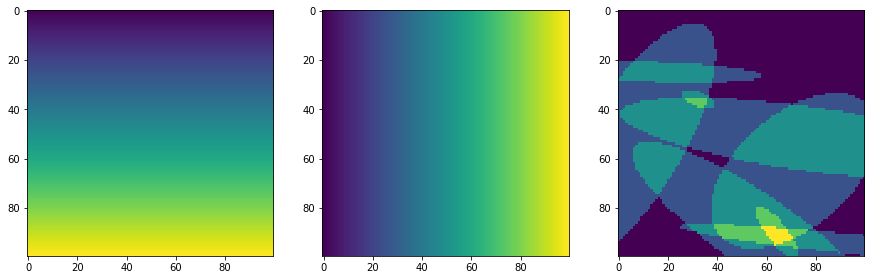

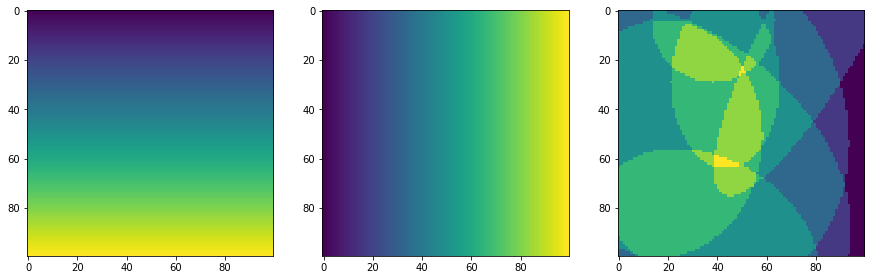

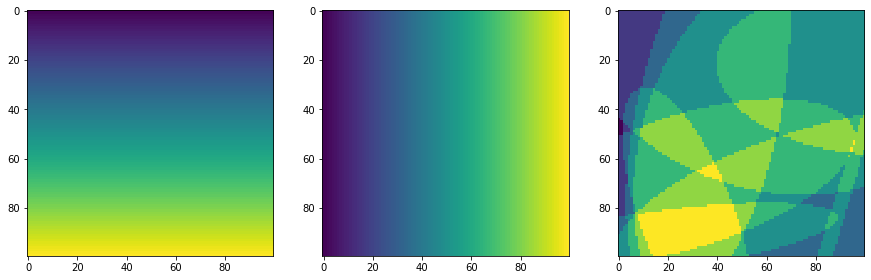

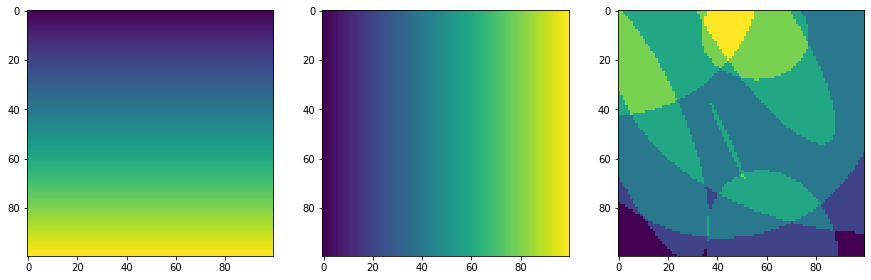

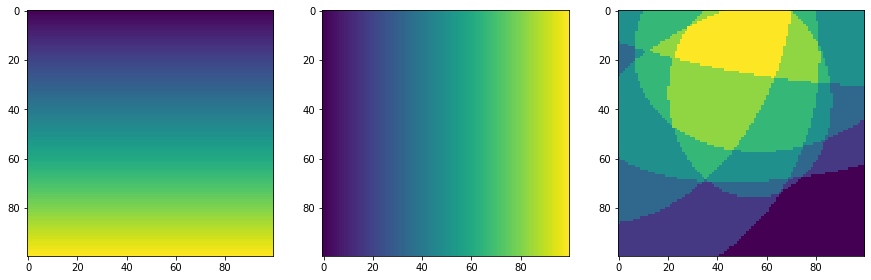

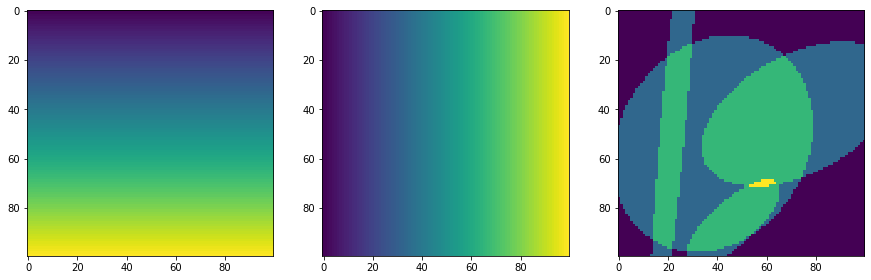

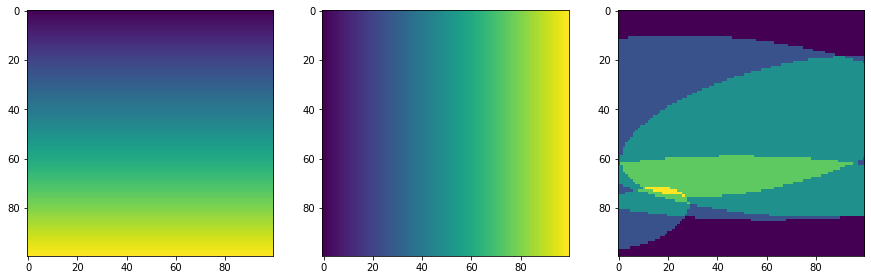

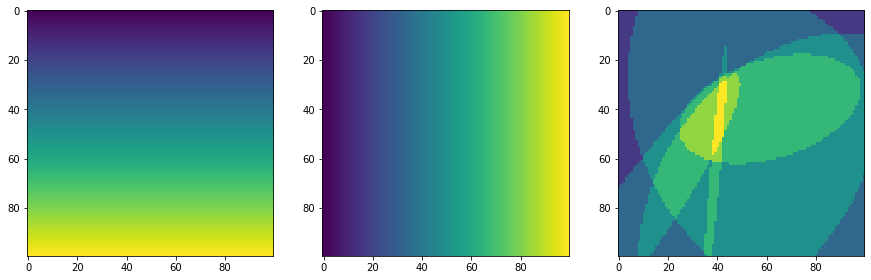

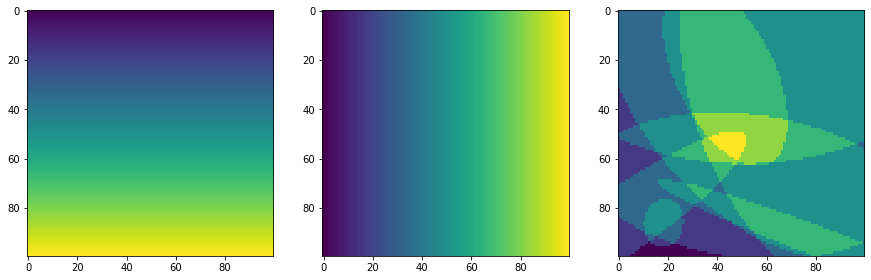

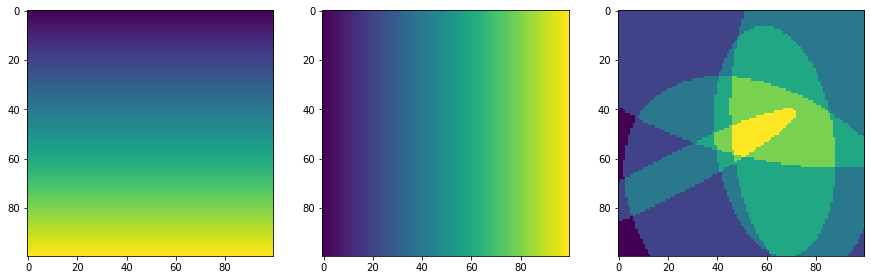

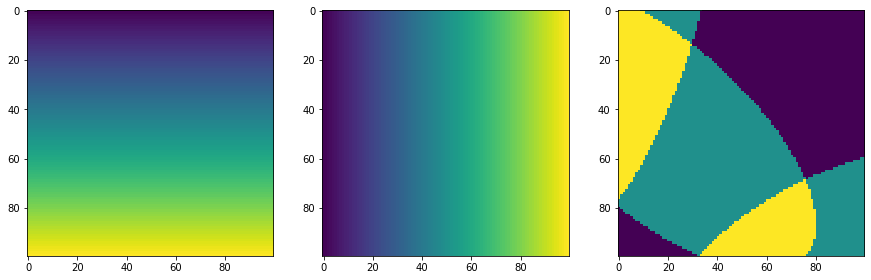

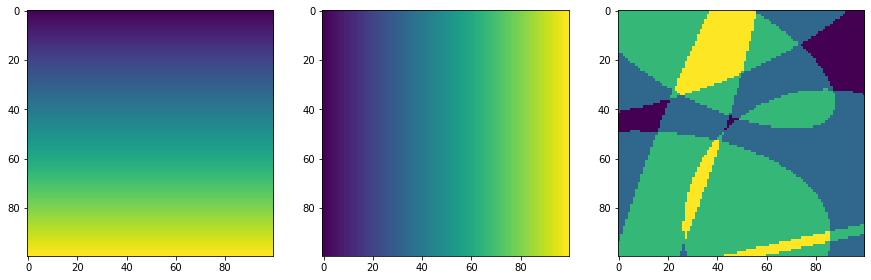

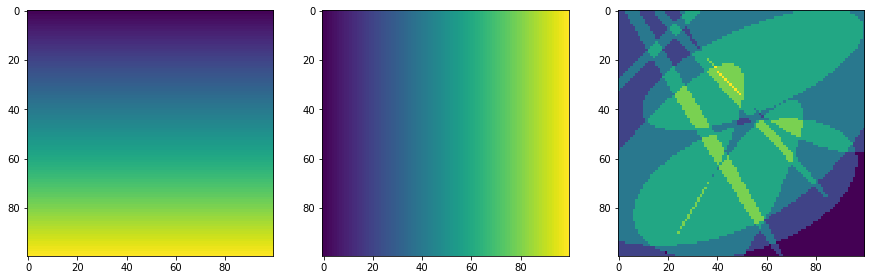

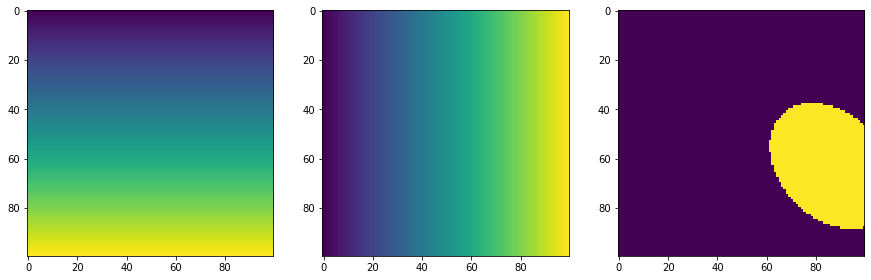

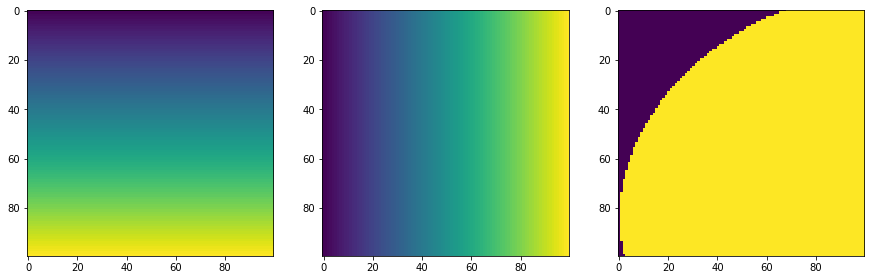

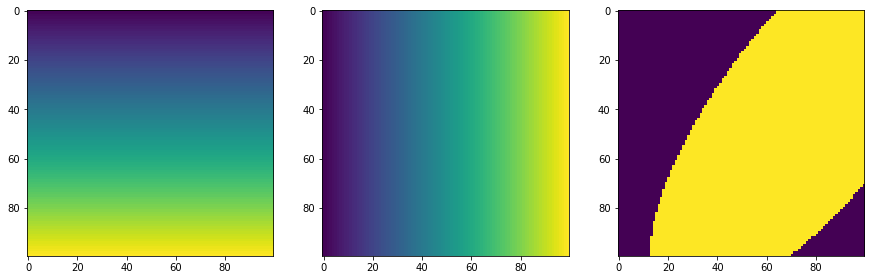

In [4]:
roop = ['x', 'y', 'z']
for j in range(len(noda)):
    fig = plt.figure(figsize=(15,15))
    for i, v in enumerate(roop):
        fig.add_subplot(1,3,i+1)
        plt.imshow(noda[j][roop[i]])
    plt.show()